In [ ]:
from yggdrasil.runner import run
from yggdrasil import tools
import trimesh
import pickle

# Time Step Synchronization

In addition to allowing models to call other models as functions, yggdrasil also provides a method of synchronizing data across time dependent models, even if the models have different time steps. To see how this works in practice, the following shows how we could connect the shoot model from the previous notebooks with the time-dependent root growth model.

The cell below displays the source code for a root model which calculates the mass of the roots as a function of time and then sames the root data to a file.

In [ ]:
tools.display_source('models/roots_v0.py', number_lines=True)

Similarly to the shoot model, the YAML displayed below runs the above root model without any connections.

In [ ]:
tools.display_source('yamls/roots_v0.yml', number_lines=True)
run(['yamls/roots_v0.yml'], production_run=True)

The cell below plots the resulting masses.

In [ ]:
import matplotlib.pyplot as plt
filename_masses = 'output/masses.pkl'
with open(filename_masses, 'rb') as fd:
    masses = pickle.load(fd)
plt.plot(masses['times'], masses['masses'])

To allow this root model to share mass data with the shoot model, the yaml for the new root and shoot models will include a `timesync` parameter specifying the name of a dummy timesync "model" (in this case `shoot2root`). The name is used to group models that should be synchronized and models can connect to multiple synchronization groups by providing a list of timesync model names to the `timesync` parameter.

In [ ]:
tools.display_source_diff('yamls/roots_v0.yml', 'yamls/roots_v1.yml', number_lines=True)
tools.display_source_diff('yamls/shoot_v2.yml', 'yamls/shoot_v3.yml', number_lines=True)

In addition, the we will also need to create a YAML entry for the dummy timesync "model" that specifies how data between models connecting to it should be aggregated (in this case by summing). This entry could be in the plant or root yaml, but is keep separate here for brevity.

In [ ]:
tools.display_source('yamls/timesync.yml', number_lines=True)

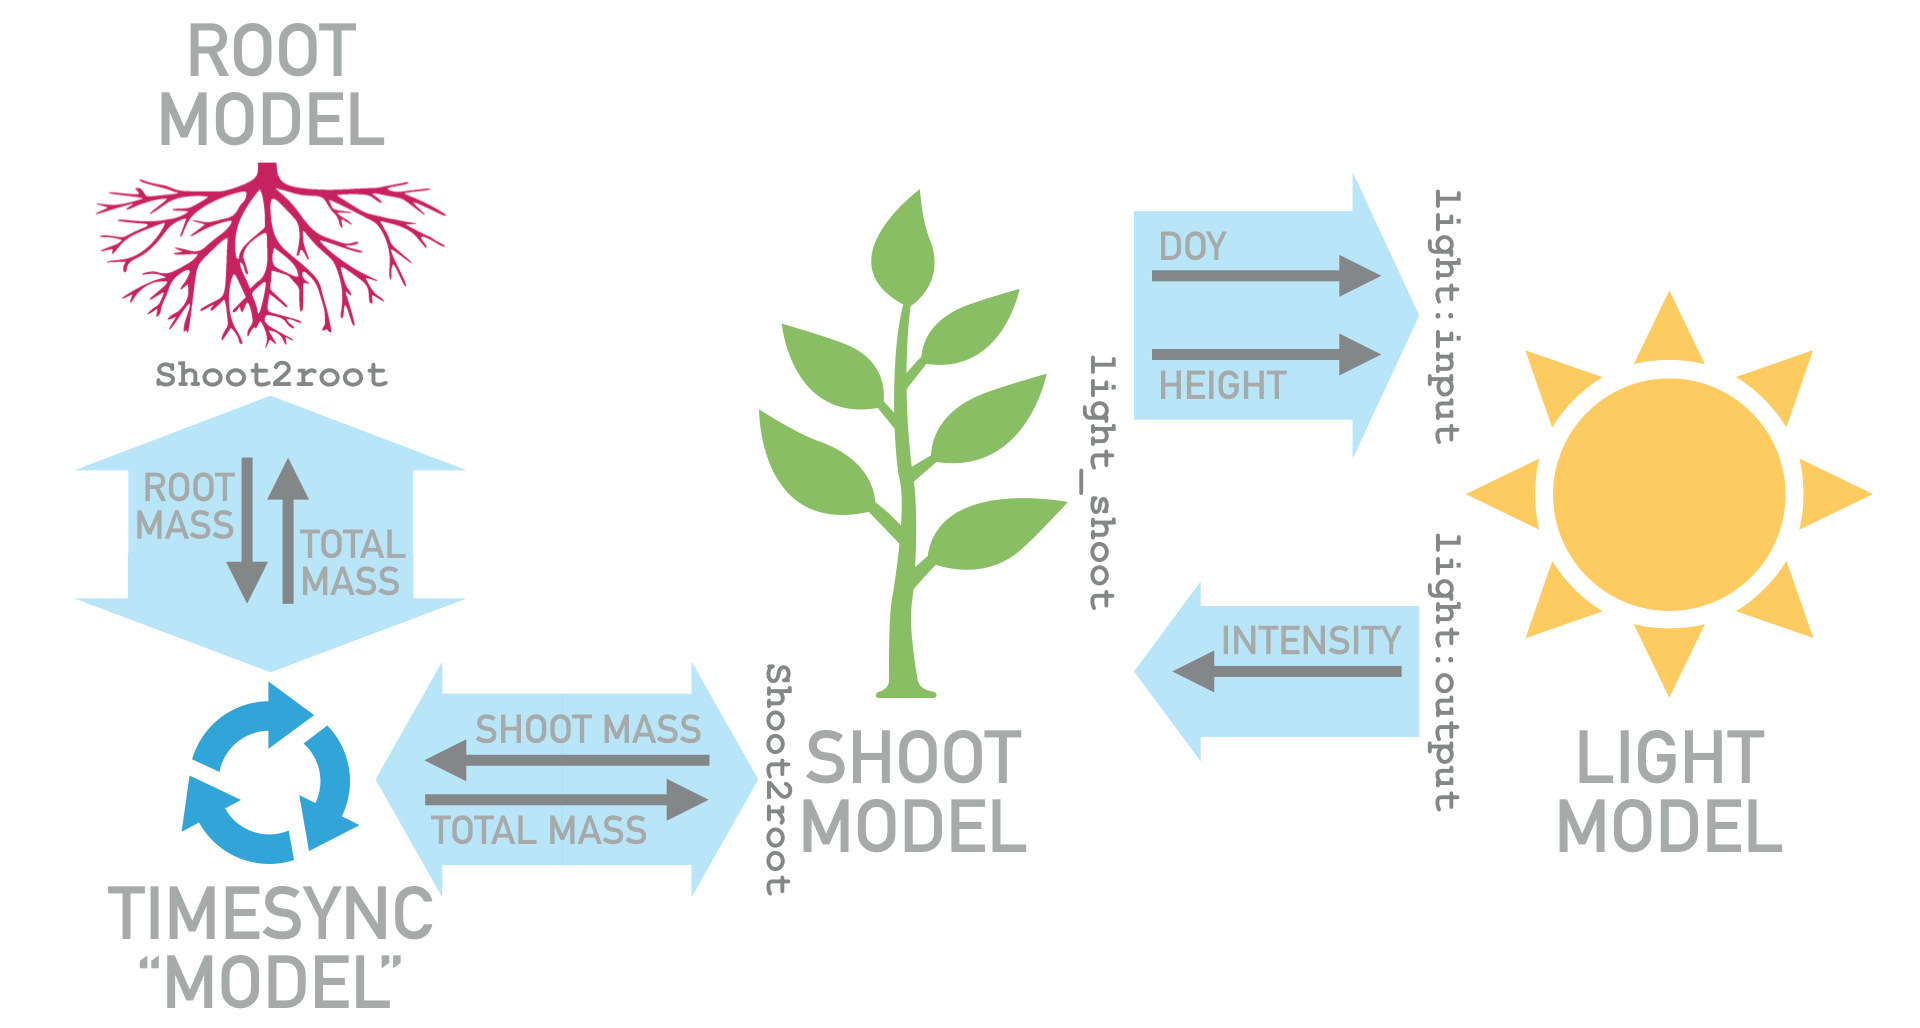

The source code for the updated root and shoot models then contain and additional interface comm for connecting to the time step synchronization model. The name passed to the `YggTimesync` time step synchronization interface is the `timesync` param from the root model YAML (also the name of the dummy timesync model). 

These interfaces are both used in time loop, with the `YggTimesync` interface being "called" using the same syntax as the `YggRpcClient` interface used in the previous server/client RPC example.

In [ ]:
tools.display_source_diff('models/roots_v0.py', 'models/roots_v1.py', number_lines=True)
tools.display_source_diff('models/shoot_v2.py', 'models/shoot_v3.py', number_lines=True)

This integration can then be run by providing the models for the updated shoot & root models, the light model, and the timesync model to the yggdrasil `run` method.

In [ ]:
run(['yamls/shoot_v3.yml', 'yamls/roots_v1.yml', 'yamls/light_v1_python.yml', 'yamls/timesync.yml'], production_run=True)

In [ ]:
import matplotlib.pyplot as plt
filename_masses = 'output/masses.pkl'
with open(filename_masses, 'rb') as fd:
    masses = pickle.load(fd)
plt.plot(masses['times'], masses['masses'])

# Interpolation & Aggregation

You may not have noticed, but the root and shoot model do not have the same time step. The root model time step was 0.5 days and the shoot model time step was 6.0 hrs. The timesync "model" handles differences in time step by interpolating. 

When a model sends a request to the timesync channel for a time step, the timesync model checks for messages from the other models at or after the requested time. If there is data for all of the models, the timesync model interpolates between the existing data for each model to determine a value at the requested timestep and then aggregates the data as directed by the YAML. If there is data missing, the timesync model will wait until the required data is received before responding.

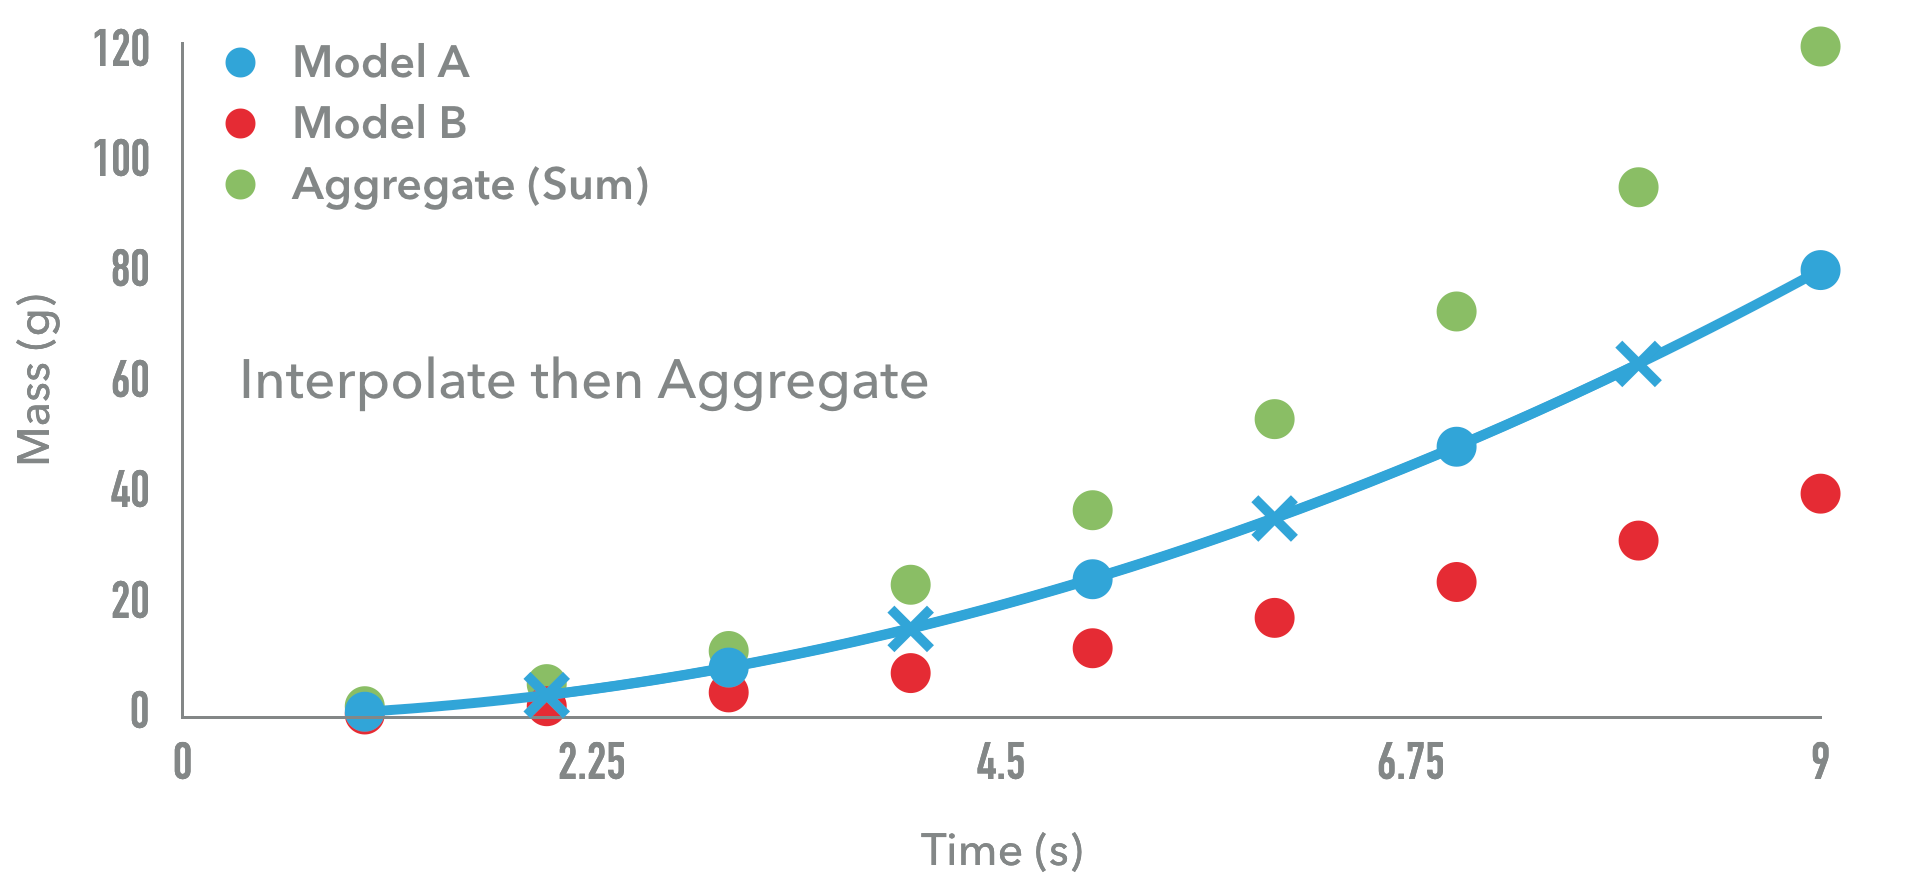